# series oof df
series_idごとのoof scoreをチェック
errorがどういう波形に対して発生しているかを確認する

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

import warnings
warnings.filterwarnings('ignore')


In [2]:
import sys
sys.path.append("/kaggle/src/dss_utils")

from dss_metrics import score


# Config

In [3]:
output_dir = os.path.join("/kaggle", "working", "_oof")
# exp_name = "exp006_addlayer"
# exp_name = "debug"
exp_name = "exp017_inputtargettd_flip_epoch10"


In [4]:
event_df = pd.read_csv("/kaggle/input/child-mind-institute-detect-sleep-states/train_events.csv")
event_df = event_df.dropna()


# fn

In [5]:
# 1step 0.5secで30minなら60*30=1800step
def postprocess_fn(df, N=3, maxpool_kernel_size=3, maxpool_stride=1):
    df = df.copy()
    df = df[df["second"]==0].reset_index(drop=True)
    df["class_pred_beforemean"] = df.groupby("series_id")["class_pred"].apply(lambda x: x.rolling(N, min_periods=1).mean())
    df["class_pred_aftermean"] = df.groupby("series_id")["class_pred"].apply(lambda x: x[::-1].rolling(N, min_periods=1).mean()[::-1])
    df["event_pred"] = df["class_pred_beforemean"] - df["class_pred_aftermean"]
    not_predicted_mask = (df["class_pred"] != -1).astype(int)
    df["event_pred"] = df["event_pred"] * not_predicted_mask

    # 入力サイズと出力サイズが一致するようにpaddingを調整
    maxpool_padding = int((maxpool_kernel_size - maxpool_stride) / 2)
    # maxpoolしてピーク検出
    max_pooling = nn.MaxPool1d(maxpool_kernel_size, stride=maxpool_stride, padding=maxpool_padding)
    event_pred = df["event_pred"].values
    event_pred = torch.tensor(event_pred).unsqueeze(0)
    pooled_event_pred = max_pooling(np.abs(event_pred)).squeeze(0).numpy()
    event_pred = event_pred.squeeze(0).numpy()
    # peakのところだけ残すmaskを作成
    peak_event_pred_mask = np.where(pooled_event_pred == np.abs(event_pred), 1, 0)
    peak_event_pred = event_pred * peak_event_pred_mask
    df["event_pred"] = peak_event_pred
    df = df.drop(["class_pred_beforemean", "class_pred_aftermean"], axis=1)
    return df

def make_submission_df(df, threshold=0.1):
    df = df[["series_id", "step", "event_pred"]].copy()
    # thresholdより大きいときは1,-thresholdより小さいときは-1,それ以外は0
    df["event"] = df["event_pred"].apply(lambda x: 1 if x > threshold else -1 if x < -threshold else 0)
    df = df[df["event"] != 0].copy()
    df["event"] = df["event"].replace({1: "wakeup", -1: "onset"})
    df["score"] = df["event_pred"].apply(lambda x: np.clip(np.abs(x), 0.0, 1.0))
    return df


---
# make sub df

In [6]:
sub_df = pd.DataFrame()
for i in range(5):
    print("fold", i)
    df = pd.read_parquet(os.path.join(output_dir, exp_name, f"oof_df_fold{i}.parquet"))
    print("postprocess_fn")
    df = postprocess_fn(df, N=11, maxpool_kernel_size=3, maxpool_stride=1)
    sub_df_ = make_submission_df(df, threshold=0.01)
    sub_df_["step"] = sub_df_["step"].astype(np.float64)
    event = event_df[event_df["series_id"].isin(df["series_id"].unique())].copy().reset_index(drop=True)
    print("score", score(event, sub_df_))

    sub_df = pd.concat([sub_df, sub_df_], axis=0)


fold 0
postprocess_fn
score 0.7470465059010364
fold 1
postprocess_fn
score 0.7575335319444019
fold 2
postprocess_fn
score 0.7575919486485332
fold 3
postprocess_fn
score 0.7757856848671429
fold 4
postprocess_fn
score 0.7588070505332187


In [7]:
del df
import gc
gc.collect()


72

In [8]:
sub_df.to_csv(os.path.join(output_dir, exp_name, "sub_df.csv"), index=False)


---
# score check

In [9]:
sub_df = pd.read_csv(os.path.join(output_dir, exp_name, "sub_df.csv"))


In [10]:
series_id_list =[]
score_list = []
detected_event_num_list = []
for series_id in event_df["series_id"].unique():
    scoring_event_df = event_df[event_df["series_id"] == series_id].copy()
    scoring_sub_df = sub_df[sub_df["series_id"] == series_id].copy()
    if len(scoring_sub_df) == 0 or len(scoring_event_df) == 0:
        series_id_list.append(series_id)
        series_score = 0
        score_list.append(series_score)
        detected_event_num_list.append(len(scoring_sub_df))
        print(series_id, series_score, len(scoring_sub_df), len(scoring_event_df))
    else:
        series_score = score(scoring_event_df, scoring_sub_df)
        series_id_list.append(series_id)
        score_list.append(series_score)
        detected_event_num_list.append(len(scoring_sub_df))
        print(series_id, series_score)


038441c925bb 0.7363336471186677
03d92c9f6f8a 0.7290361201298701
0402a003dae9 0.6650406480896232
04f547b8017d 0.8151244615798754
05e1944c3818 0.8602968460111318
062cae666e2a 0.7768939393939394
062dbd4c95e6 0.5947722625588223
08db4255286f 0.8504402853409292
0a96f4993bd7 0.6305610890471185
0cd1e3d0ed95 0.9070238095238095
0ce74d6d2106 0.8726080179733732
0cfc06c129cc 0.7945023590724442
0d0ad1e77851 0.8523185784223517
0dee4fda51c3 0.7417270648292109
0ec9fc461819 0.868132265364087
0ef7d94fde99 0.8029329632742286
0f572d690310 0.7618977290479596
10469f6765bf 0.4899350649350649
1087d7b0ff2e 0.6524362895868976
10f8bc1f7b07 0.8488474398856851
12d01911d509 0.7178096043963662
1319a1935f48 0.8025698174806961
137771d19ca2 0.85625
137b99e936ab 0.676141282683506
13b4d6a01d27 0.7375
148471991ffb 0.4577779084880059
154fe824ed87 0.795203800971098
16fe2798ed0f 0.6793679858798553
1716cd4163b2 0.7458916174894398
1762ab70ec76 0.5889644421166653
188d4b7cd28b 0.7937488859517361
18a0ca03431d 0.8058560296562332
18

In [11]:
score_df = pd.DataFrame({
    "series_id": series_id_list,
    "score": score_list,
    "detected_event_num": detected_event_num_list
})
score_df.sort_values("score", ascending=False)


,series_id,score,detected_event_num
173,aed3850f65f0,0.950000,7
65,3be2f86c3e45,0.927083,47
69,405df1b41f9f,0.919444,47
94,5e816f11f5c3,0.916667,39
9,0cd1e3d0ed95,0.907024,65
...,...,...,...
132,854206f602d0,0.306222,52
241,e4500e7e19e1,0.127249,24
81,4feda0596965,0.116124,187
258,f56824b503a0,0.082263,137


In [12]:
score_df.to_csv(os.path.join(output_dir, exp_name, "score_df.csv"), index=False)


,series_id,score,detected_event_num
0,aed3850f65f0,0.950000,7
1,3be2f86c3e45,0.927083,47
2,405df1b41f9f,0.919444,47


<Axes: >

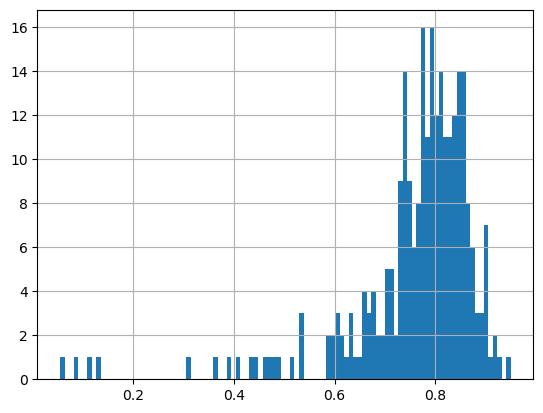

In [13]:
score_df = score_df.sort_values("score", ascending=False).reset_index(drop=True)
display(score_df.head(3))
score_df["score"].hist(bins=100)


In [14]:
score_df.tail(20)["series_id"]


249    1762ab70ec76
250    fa149c3c4bde
251    ca730dbf521d
252    1f96b9668bdf
253    d2fef7e4defd
254    4ac356361be9
255    10469f6765bf
256    73fb772e50fb
257    df33ae359fb5
258    148471991ffb
259    60e51cad2ffb
260    db5e0ee1c0ab
261    7476c0bd18d2
262    c535634d7dcd
263    b7fc34995d0f
264    854206f602d0
265    e4500e7e19e1
266    4feda0596965
267    f56824b503a0
268    60d31b0bec3b
Name: series_id, dtype: object